# Lab | Handling Data Imbalance in Classification Models

For this lab and in the next lessons we will build a model on customer churn binary classification problem. You will be using `files_for_lab/Customer-Churn.csv` file.

### Scenario

You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

### Instructions

In this lab, we will first take a look at the degree of imbalance in the data and correct it using the techniques we learned on the class.

Here is the list of steps to be followed (building a simple model without balancing the data):

- Import the required libraries and modules that you would need.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

- Read that data into Python and call the dataframe `churnData`.

In [28]:
path = "/home/sabina/Downloads/Ironhack/Unit 7/lab-handling-data-imbalance-classification/files_for_lab/Customer-Churn.csv"
churnData = pd.read_csv(path)
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


- Check the datatypes of all the columns in the data. You would see that the column `TotalCharges` is object type. Convert this column into numeric type using `pd.to_numeric` function.

In [29]:
churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"], errors="coerce")

# Check that the datatype conversion did not create any nulls
churnData["TotalCharges"].isna().sum()  # It did, we'll take care of them in the
                                        # next section.

11

- Check for null values in the dataframe. Replace the null values.

In [30]:
churnData.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [31]:
# Check what % of the churnData has null values
percentage = round(churnData.TotalCharges.isna().sum() * 100 / churnData.shape[0], 2)

print(percentage, "%")

0.16 %


In [32]:
# The amount of nulls compared to the whole data is very small, so we'll remove them:
churnData.dropna(axis=0, inplace=True)

- Use the following features: `tenure`, `SeniorCitizen`, `MonthlyCharges` and `TotalCharges`:
  - Scale the features either by using normalizer or a standard scaler.
  - Split the data into a training set and a test set.
  - Fit a logistic regression model on the training data.
  - Check the accuracy on the test data.

In [33]:
# Select data for modelling
columns = ["tenure", "SeniorCitizen", "MonthlyCharges", "TotalCharges"]

X = churnData[columns]
y = churnData["Churn"]

In [34]:
X.head()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
0,1,0,29.85,29.85
1,34,0,56.95,1889.50
2,2,0,53.85,108.15
3,45,0,42.30,1840.75
4,2,0,70.70,151.65


In [35]:
X.dtypes

tenure              int64
SeniorCitizen       int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object

In [36]:
X["SeniorCitizen"].unique()

array([0, 1])

In [37]:
# Since SeniorCitizen is a Yes/No feature, we'll consider it a categorical value
# and encode it
cat = pd.DataFrame(X["SeniorCitizen"])
cat = pd.get_dummies(cat, columns=cat.columns, drop_first=True)

In [38]:
def scale_data(num):
    transformer = MinMaxScaler().fit(num) 
    x_minmax = transformer.transform(num)
    num = pd.DataFrame(x_minmax, columns=num.columns, index=num.index)
    return num

In [39]:
# Scale numerical features
num = X.drop("SeniorCitizen", axis=1)
num = scale_data(num)

In [40]:
# Combined scaled numerical data & encoded categorical data
X = pd.concat([cat, num], axis=1)
X.shape

(7032, 4)

In [41]:
# Train-test split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
    random_state=42)

In [42]:
# Create validation functions for logistic regression
def validate_model(y_pred, y_test):
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=["No", "Yes"], \
        yticklabels=["No", "Yes"])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    print("Accuracy:", 100 * round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", 100 * round(precision_score(y_test, y_pred, pos_label="Yes"), 4))
    print("Recall:", 100 * round(recall_score(y_test, y_pred, pos_label="Yes"), 4))

def roc_auc_validation(y_pred_proba, y_test):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba, pos_label="Yes")
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

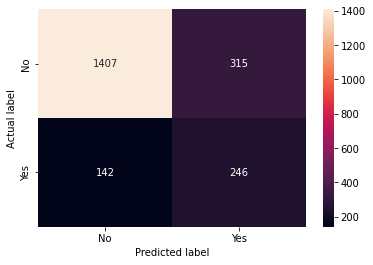

Accuracy: 78.34
Precision: 63.4
Recall: 43.85


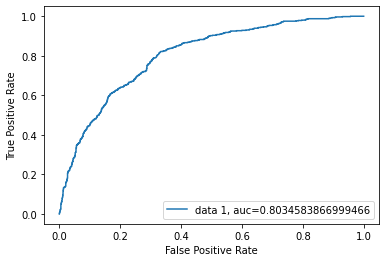

In [45]:
# Fit logistic regression linear_model to imbalanced data
linear_model = LogisticRegression(max_iter=200) #Increased number of iterations \
                                                #due to initial iterations > 100
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
y_pred_proba = linear_model.predict_proba(X_test)[:, 1]
validate_model(y_pred, y_test)
roc_auc_validation(y_pred_proba, y_test)

**Note**: So far we have not balanced the data.

Managing imbalance in the dataset

- Check for the imbalance.
- Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.
- Each time fit the model and see how the accuracy of the model is.

In [46]:
# Apply oversampling technique
X_sm, y_sm = SMOTE().fit_resample(X_train, y_train)

# Apply undersampling technique
X_tl, y_tl = TomekLinks().fit_resample(X_train, y_train)

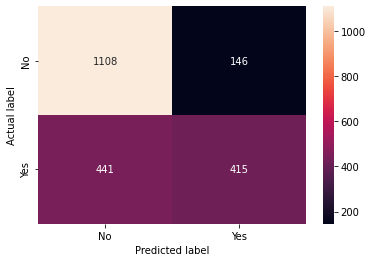

Accuracy: 72.18
Precision: 48.480000000000004
Recall: 73.98


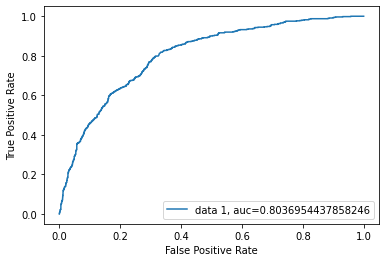

In [47]:
# Fit logistic regression linear_model to oversampled data
linear_model = LogisticRegression(max_iter=200) #Increased number of iterations \
                                                #due to initial iterations > 100
linear_model.fit(X_sm, y_sm)
y_pred = linear_model.predict(X_test)
y_pred_proba = linear_model.predict_proba(X_test)[:, 1]
validate_model(y_pred, y_test)
roc_auc_validation(y_pred_proba, y_test)

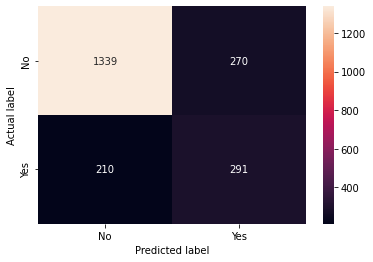

Accuracy: 77.25
Precision: 58.08
Recall: 51.870000000000005


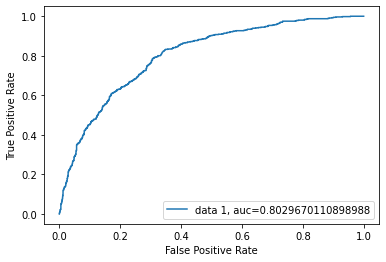

In [48]:
# Fit logistic regression linear_model to undersampled data
linear_model = LogisticRegression(max_iter=200) #Increased number of iterations \
                                                #due to initial iterations > 100
linear_model.fit(X_tl, y_tl)
y_pred = linear_model.predict(X_test)
y_pred_proba = linear_model.predict_proba(X_test)[:, 1]
validate_model(y_pred, y_test)
roc_auc_validation(y_pred_proba, y_test)

We notice that the SMOTE technique drastically improves recall whilst decreasing some of the precision of the model, overall improving the model only slightly, whereas TomekLinks only improves recall and decreases precision by a little, resulting in an overall worse performance (based on the ROC_AUC).